# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


**Import necessary libraries:**

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

In [0]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


**Let's view what's the data:**

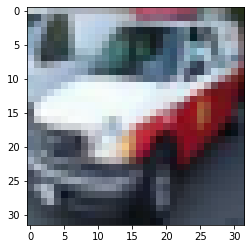

In [0]:
plt.imshow(X_train[60])

**Let's view few more images fron the file:**

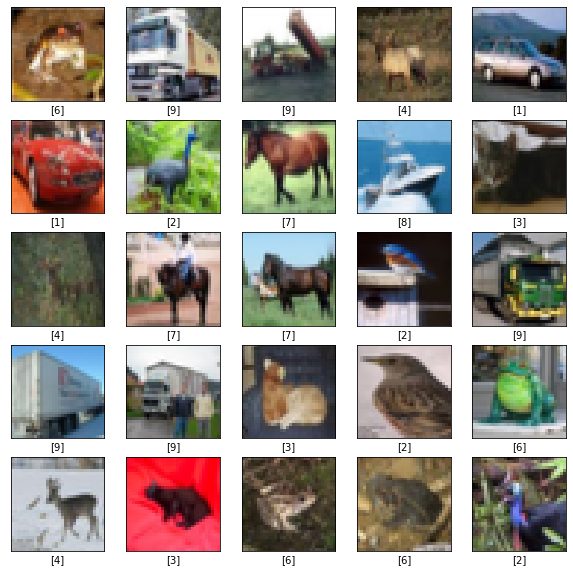

In [0]:
plt.figure(figsize=(10,10))
for img in range(25):
    plt.subplot(5, 5, img+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[img])
    plt.xlabel(y_train[img])
plt.show()

**Shape of data:**

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


**Check unique count of target data in y_train:**

In [0]:
y_train_unq, y_train_unq_cnt = np.unique(y_train, return_counts=True)
print("Frequency of unique values in y_train:")
print(np.asarray((y_train_unq, y_train_unq_cnt)))

Frequency of unique values in y_train:
[[   0    1    2    3    4    5    6    7    8    9]
 [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]]


**Check unique count of target data in y_test:**

In [0]:
y_test_unq, y_test_unq_cnt = np.unique(y_test, return_counts=True)
print("Frequency of unique values in y_test:")
print(np.asarray((y_test_unq, y_test_unq_cnt)))

Frequency of unique values in y_test:
[[   0    1    2    3    4    5    6    7    8    9]
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]]


**Convert target into 1-D array for further processing:**

In [0]:
y_train = y_train.ravel()

y_test  = y_test.ravel()

In [0]:
y_train[0:5]

array([6, 9, 9, 4, 1], dtype=uint8)

**Split the data into 2: One with classes 0-4 and other with classes 5-9:**

In [0]:
X_train_1 = X_train[y_train <= 4]
y_train_1 = y_train[y_train <= 4]
X_test_1  = X_test[y_test <= 4]
y_test_1  = y_test[y_test <= 4]


X_train_2 = X_train[y_train > 4]
y_train_2 = y_train[y_train > 4]
X_test_2  = X_test[y_test > 4]
y_test_2  = y_test[y_test > 4]

**Check the shape of data now:**

In [0]:
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)

print(X_test_1.shape)
print(y_test_1.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(25000, 32, 32, 3)
(25000,)
(25000, 32, 32, 3)
(25000,)
(5000, 32, 32, 3)
(5000,)
(5000, 32, 32, 3)
(5000,)


**Check if data is correctly split:**

In [0]:
np.unique(y_test_1)

array([0, 1, 2, 3, 4])

In [0]:
np.unique(y_test_2)

array([5, 6, 7, 8, 9])

### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

**One-hot encoding:**

In [0]:
y_train_1 = tf.keras.utils.to_categorical(y_train_1, num_classes = 5)
y_test_1  = tf.keras.utils.to_categorical(y_test_1, num_classes = 5)

*   In y_train_2 & y_test_2, class labels will start from 5 to 9 but for keras.utils.to_categorical the labels should start from 0
*   so I will subtract 5 from train and test labels



In [0]:
y_train_2 = y_train_2 - 5
y_test_2  = y_test_2  - 5

y_train_2 = tf.keras.utils.to_categorical(y_train_2, num_classes = 5)
y_test_2  = tf.keras.utils.to_categorical(y_test_2, num_classes = 5)

**Convert values to float & Normalize:**

In [0]:
# Making sure that the values are float 
X_train_1 = X_train_1.astype('float32')
X_test_1  = X_test_1.astype('float32')

X_train_2 = X_train_2.astype('float32')
X_test_2  = X_test_2.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train_1/= 255
X_test_1/=255

X_train_2/= 255
X_test_2/=255

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [0]:
input_shape = (32, 32, 3)
num_classes = 5

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation="relu", name="Conv_layer1"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", name="Conv_layer2"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu", name="Conv_layer3"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation="relu", name="Dense_layer"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="Output"))                               

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Mount drive to save the best model for future use:**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Fit the model:**

In [0]:
# Save the best model after every epoch. Since accuracy is monitored, we give mode as max
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/CNN/CIFAR/model.h5', monitor='accuracy', 
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

model.fit(X_train_1, y_train_1, validation_data=(X_test_1, y_test_1), epochs=20, batch_size=128, callbacks=callbacks_list)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
24960/25000 [============================>.] - ETA: 0s - loss: 1.1319 - accuracy: 0.5580
Epoch 00001: accuracy improved from -inf to 0.55808, saving model to /content/drive/My Drive/CNN/CIFAR/model.h5
25000/25000 [==============================] - 38s 2ms/sample - loss: 1.1314 - accuracy: 0.5581 - val_loss: 2.9197 - val_accuracy: 0.2000
Epoch 2/20
24960/25000 [============================>.] - ETA: 0s - loss: 0.8419 - accuracy: 0.6659
Epoch 00002: accuracy improved from 0.55808 to 0.66604, saving model to /content/drive/My Drive/CNN/CIFAR/model.h5
25000/25000 [==============================] - 37s 1ms/sample - loss: 0.8416 - accuracy: 0.6660 - val_loss: 3.0891 - val_accuracy: 0.2086
Epoch 3/20
24960/25000 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.7460
Epoch 00004: accuracy improved from 0.71684 to 0.74588, saving model to /content/drive/My Drive/CNN/CIFAR/model.h5
25000/25000 [====================

**Model Summary:**

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1 (Conv2D)         (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
Conv_layer2 (Conv2D)         (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0

**Model Accuracy:**

In [0]:
final_model = tf.keras.models.load_model('/content/drive/My Drive/CNN/CIFAR/model.h5')
score = final_model.evaluate(X_test_1, y_test_1, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 83.52%


**Confusion matrix:**

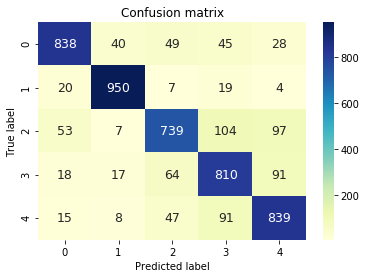

In [0]:
y_pred_1 = final_model.predict_classes(X_test_1)

cm1 = confusion_matrix(y_test_1.argmax(axis=1), y_pred_1)

plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm1), annot=True, annot_kws={"fontsize":12.5}, cmap='YlGnBu', fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Classification Report:**

In [0]:
print(classification_report(y_test_1.argmax(axis=1), y_pred_1))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1000
           1       0.93      0.95      0.94      1000
           2       0.82      0.74      0.78      1000
           3       0.76      0.81      0.78      1000
           4       0.79      0.84      0.81      1000

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



### **Inference:**

- Overall accuracy of the model on the test data is 83.52%
- As seen in confusion matrix and classification report, Class 1 has been precicted correctly most often, follwed by Class 0

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [0]:
for layer in final_model.layers:
    if (layer.name == 'Conv_layer1' or layer.name == 'Conv_layer2' or layer.name == 'Conv_layer3'):
        print(layer.name)
        layer.trainable = False

Conv_layer1
Conv_layer2
Conv_layer3


### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [0]:
final_model.fit(X_train_2, y_train_2, validation_data=(X_test_2, y_test_2), epochs=20, batch_size=128)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 37s 1ms/sample - loss: 0.8317 - accuracy: 0.7501 - val_loss: 0.4630 - val_accuracy: 0.8278
Epoch 2/20
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.4215 - accuracy: 0.8470 - val_loss: 0.4446 - val_accuracy: 0.8278
Epoch 3/20
25000/25000 [==============================] - 36s 1ms/sample - loss: 0.3555 - accuracy: 0.8702 - val_loss: 0.4507 - val_accuracy: 0.8306
Epoch 4/20
25000/25000 [==============================] - 36s 1ms/sample - loss: 0.3148 - accuracy: 0.8852 - val_loss: 0.3165 - val_accuracy: 0.8818
Epoch 5/20
25000/25000 [==============================] - 36s 1ms/sample - loss: 0.2778 - accuracy: 0.8986 - val_loss: 0.3297 - val_accuracy: 0.8790
Epoch 6/20
25000/25000 [==============================] - 37s 1ms/sample - loss: 0.2482 - accuracy: 0.9099 - val_loss: 0.3341 - val_accuracy: 0.8782
Epoch 7/20
25000/25000 [==============================] -

**Model Summary:**

In [0]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1 (Conv2D)         (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
Conv_layer2 (Conv2D)         (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0

**Accuracy on Class II data:**

In [0]:
final_score = final_model.evaluate(X_test_2, y_test_2, verbose=0)
print("Accuracy: %.2f%%" % (final_score[1]*100))

Accuracy: 90.00%


**Confusion matrix:**

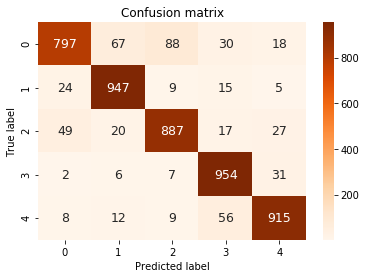

In [0]:
y_pred_2 = final_model.predict_classes(X_test_2)

cm2 = confusion_matrix(y_test_2.argmax(axis=1), y_pred_2)

plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm2), annot=True, annot_kws={"fontsize":12.5}, cmap='Oranges', fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Classification report:**

In [0]:
print(classification_report(y_test_2.argmax(axis=1), y_pred_2))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1000
           1       0.90      0.95      0.92      1000
           2       0.89      0.89      0.89      1000
           3       0.89      0.95      0.92      1000
           4       0.92      0.92      0.92      1000

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



### **Inference:**

- Overall accuracy of the model has increased after bringing in transfer learning. Accuracy on the test data is 90%
- As seen in confusion matrix and classification report, Class 1, 3 & 4 have been precicted correctly most often, follwed by Class 2 & 0

# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [0]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [0]:
# Check type of data:
type(twenty_train)

sklearn.utils.Bunch

In [0]:
# Check the keys in data:
twenty_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

As seen, we have the below parts in the data:
*   data
*   filenames
*   target_names
*   target
*   DESCR






In [0]:
# Check length of train data:
len(twenty_train['data'])

2257

In [0]:
# Let's check what's the data:
twenty_train.data[0:10]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 8. Test data

In [0]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [0]:
# Check what's the target:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [0]:
# Check unique classes in target:
np.unique(twenty_train.target)

array([0, 1, 2, 3])

In [0]:
# Check what can be the possible targets:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [0]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [0]:
vect = TfidfVectorizer(stop_words='english')
twenty_train_dtm = vect.fit_transform(twenty_train.data)
twenty_test_dtm = vect.transform(twenty_test.data)

In [0]:
# Check train shape:
twenty_train_dtm.shape

(2257, 35482)

In [0]:
# Check test shape: 
twenty_test_dtm.shape

(1502, 35482)

### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [0]:
# Use logistic regression:
logreg = LogisticRegression()

In [0]:
# Fit Logistic Regression model:
logreg.fit(twenty_train_dtm, twenty_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Predict classes on test_data:
y_pred_class_lr = logreg.predict(twenty_test_dtm)

In [0]:
# Print accuracy
print(metrics.accuracy_score(twenty_test.target, y_pred_class_lr))

0.9054593874833555


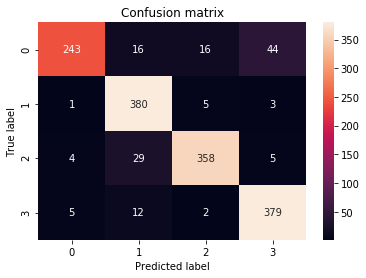

In [0]:
# Confusion matrix:
cm3 = confusion_matrix(twenty_test.target, y_pred_class_lr)

plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm3), annot=True, annot_kws={"fontsize":10}, cmap='rocket', fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Classification Report:**

In [0]:
print(classification_report(twenty_test.target, y_pred_class_lr))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       319
           1       0.87      0.98      0.92       389
           2       0.94      0.90      0.92       396
           3       0.88      0.95      0.91       398

    accuracy                           0.91      1502
   macro avg       0.91      0.90      0.90      1502
weighted avg       0.91      0.91      0.90      1502



### **Inference:**

- Overall accuracy of the Logistic regression model on the test data is 90.55%
- As seen in confusion matrix and classification report, Class 1 & 2 have been precicted correctly most often, follwed by Class 3 & 0

## **Overall Inference:**

**CNN:**
- Imported CIFAR10 data
- Splitted the data into  datasets - One with data having classes 0 to 4 and the other with classes 5 to 9
- After all the data preprocessing, built an CNN model on the first data set with an accuracy of 83.52%
- Applied transfer learning concept by making only the dense layers as trainable and used this derived model to predict the data on the second dataset
- This time accuracy boosted to 90%

**NLP:**
- Imported fetch_20newsgroups data
- Used TF-Idf vectorizer on the train and test data 
- Applied logistic regression model on the data with an accuracy of 90.55% on the test data

### <center> **End of R8_External_Lab** </center>